In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jupyter_black

jupyter_black.load()

In [3]:
import numpy as np
from scipy.io.wavfile import read

from acoustics.impulse import convolve_display
from acoustics.plot import compare, compare_impulse_responses, plot
from acoustics.porous_absorbers import materials, porous_absorber
from acoustics.rew import rew_impulse_responses, rew_measurements, rew_rt60s

In [4]:
# Data pulled from decay-time
%store -r volume

In [5]:
sample_rate, sample_data = read("../sounds/satellite.wav")

In [6]:
directory = "data/2024-05-07_front"
measurements = rew_measurements(directory)
rt60s = rew_rt60s(directory)
impulse_responses = rew_impulse_responses(directory)

rate = next(iter(impulse_responses.values()))["rate"]

In [7]:
# REW lost connection to the audio interface between the empty and frames measurement and as a result
# empty has a DC offset in its SPL, this should correct that offset enough for our purposes
measurements["front-empty-p1-l-offset"] = dict(measurements["front-empty-p1-l"])
offset = np.average(measurements["front-empty-p1-l"]["spl"]) - np.average(
    measurements["front-frames-p1-l"]["spl"]
)
measurements["front-empty-p1-l-offset"]["spl"] = (
    measurements["front-empty-p1-l"]["spl"] - offset
)

## Front Treatments

3d model of the room with the treatments under test highlighted:

<img src="../images/front-model.png" width=500/>

There are 8 cells total, 4 left and 4 right. The cell dimensions and porous absorber model predictions for various incidence angles below. 

The material's sigma is 20000α
Its thickness is 0.089m leaving an air gap of 0.013m
Its modeled average absorption coefficent is 0.7439330421492896
Resulting in an average Sa of 0.48271955272462025 and predicted reduction of 18ms


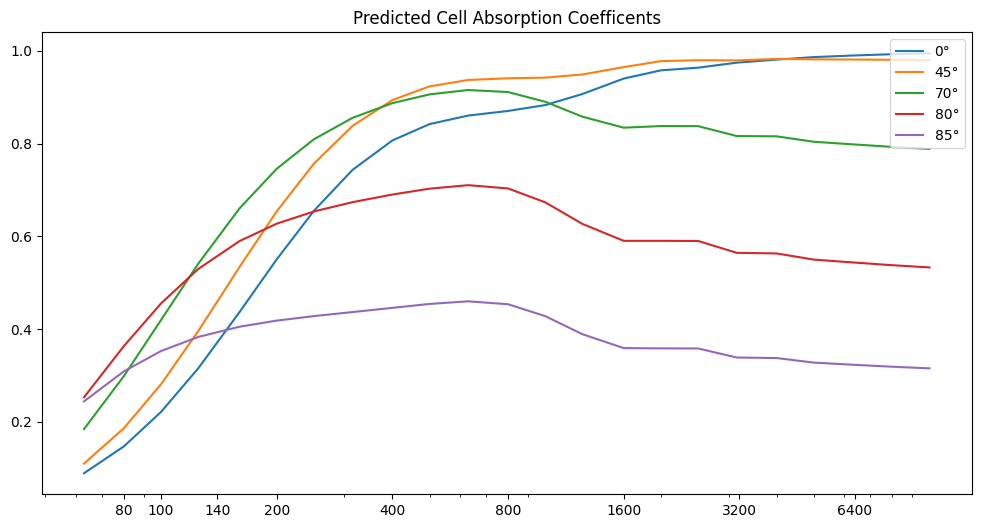

In [8]:
cell_width = 0.725
cell_height = 0.895
cell_depth = 0.1016

f = rt60s["front-frames-p1-l"]["freq"]
material = materials["OC Fire & Sound Plus R-15"]
print(f"The material's sigma is {material['sigma']}α")
thickness = material["thickness"]
air_gap = cell_depth - thickness
print(f"Its thickness is {thickness:.3f}m leaving an air gap of {air_gap:.3f}m")
cell_a = porous_absorber(
    f,
    sigma=material["sigma"],
    thickness=thickness,
    air_gap=air_gap,
)
print(f"Its modeled average absorption coefficent is {np.average(cell_a)}")
cell_Sa = cell_a * (cell_width * cell_height)
cell_dTm = 0.161 * volume / (1 - cell_Sa)
print(
    f"Resulting in an average Sa of {np.average(cell_Sa)} and predicted reduction of {np.average(cell_dTm):.0f}ms"
)
ax = plot(
    f,
    {
        "0°": cell_a,
        "45°": porous_absorber(
            f,
            sigma=material["sigma"],
            thickness=thickness,
            air_gap=air_gap,
            angle=45,
        ),
        "70°": porous_absorber(
            f,
            sigma=material["sigma"],
            thickness=thickness,
            air_gap=air_gap,
            angle=70,
        ),
        "80°": porous_absorber(
            f,
            sigma=material["sigma"],
            thickness=thickness,
            air_gap=air_gap,
            angle=80,
        ),
        "85°": porous_absorber(
            f,
            sigma=material["sigma"],
            thickness=thickness,
            air_gap=air_gap,
            angle=85,
        ),
    },
    "Predicted Cell Absorption Coefficents",
)

## Empty Frames

<img src="../images/front-frame.jpg" width=500/>

The frames are constructed with a 18mm baltic birch top plate, and 12mm bb mid and bottom plates. The risers are square 18mm bb pieces inset into the plates.

This first test compares the empty walls to all 4 frames hung without any porous absorbent. The concusion here is that the frames are acoustically negligible as expected.

In [9]:
def compare_measurements(a, b, title):
    a_data = measurements[a]
    freq = a_data["freq"]
    skip = len(freq[freq <= 30])
    ax1, ax2 = compare(
        a_data["freq"][skip:],
        a,
        a_data["spl"][skip:],
        b,
        measurements[b]["spl"][skip:],
        f"{title} - SPL",
    )

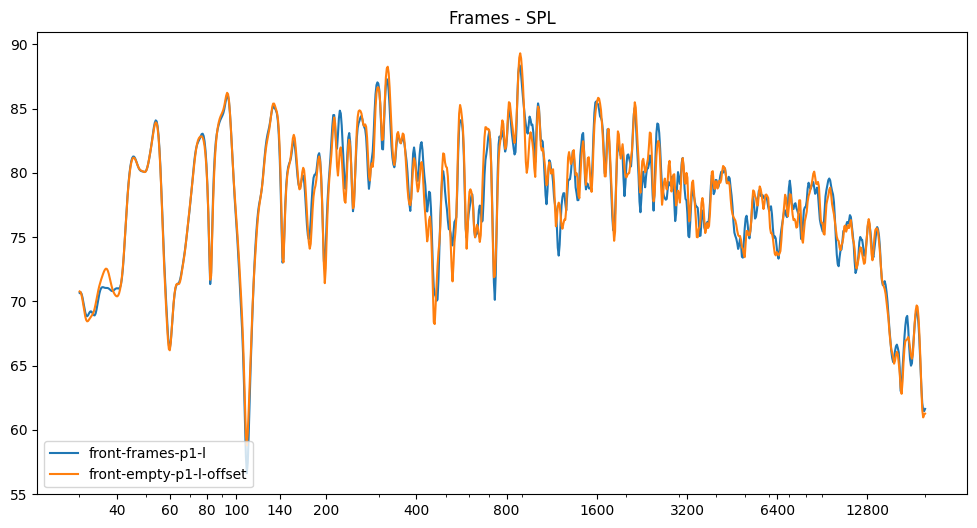

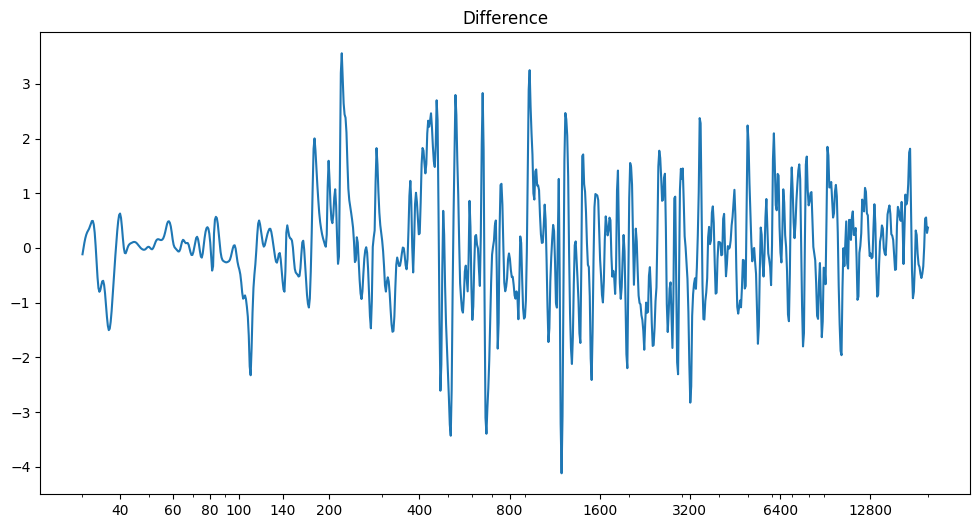

In [10]:
compare_measurements("front-frames-p1-l", "front-empty-p1-l-offset", "Frames")

## Left 1

<img src="../images/front-l1.jpg" width=500/>

Both cells of the frontmost left frame were filled with Owens Corning Thermafiber Fire & Sound Guard Plus R15, https://www.owenscorning.com/en-us/insulation/products/thermafiber-fire-and-sound-guard-plus.

There was a bit of attenuation from around 200Hz up and interestingly the predominate room mode around 110Hz saw a 5db reduction.

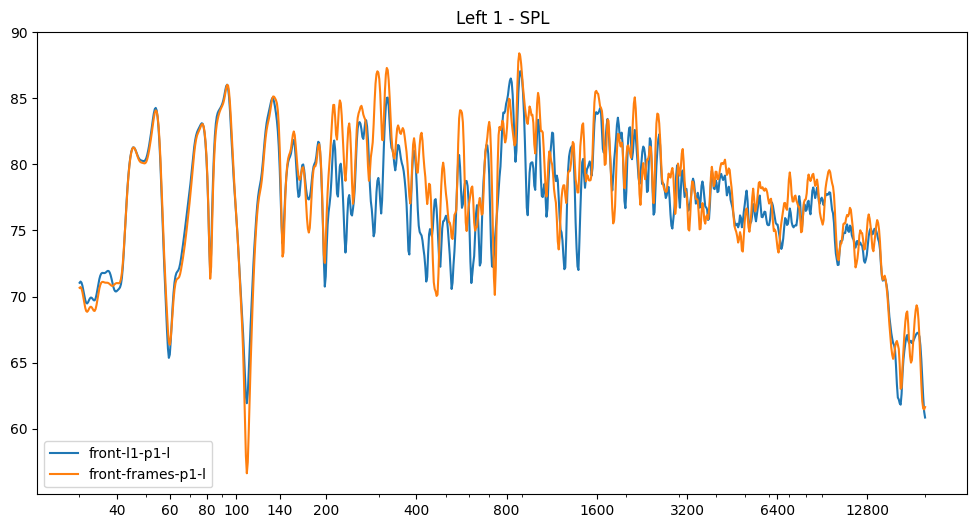

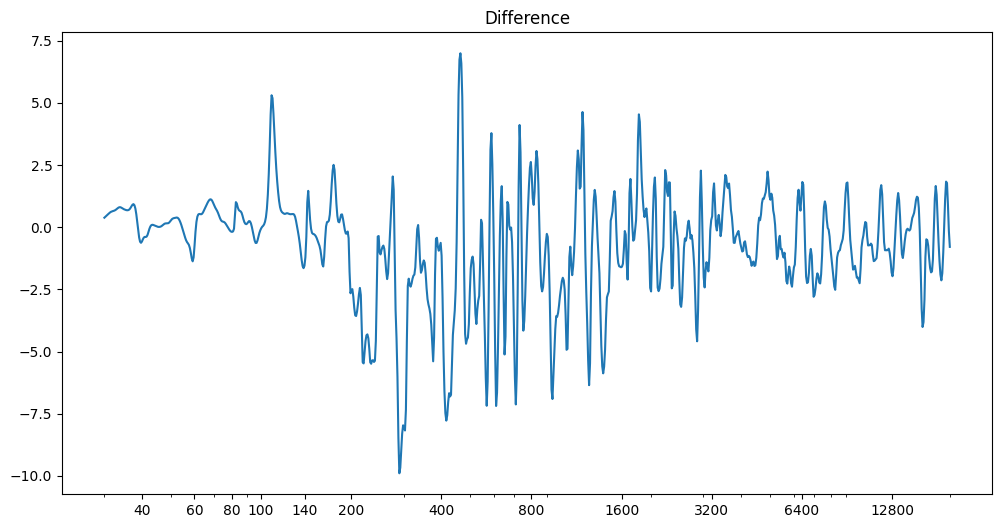

In [11]:
compare_measurements("front-l1-p1-l", "front-frames-p1-l", "Left 1")

In [12]:
def compare_topts(a, b, title, n=0):
    a_data = rt60s[a]
    b_data = rt60s[b]
    change = np.average(a_data["topt"]) - np.average(b_data["topt"])
    ax1, ax2 = compare(
        a_data["freq"],
        a,
        a_data["topt"],
        b,
        b_data["topt"],
        f"{title}: {change*1000:.0f}ms",
    )
    ax1.set_ylabel("secs")

    if n:
        ax2.plot(
            a_data["freq"], n * cell_dTm / -1000.0, label="Predicted", color="green"
        )
        ax2.legend(loc="lower left")
    ax2.set_ylabel("secs")
    ax2.axhline(0, color="black")


def per_channel_topts(a, b):
    print(f"topt({b}) topt({a}) change")
    for ch in ("l", "r", "c"):
        a_avg = np.average(rt60s[f"{a}-{ch}"]["topt"])
        b_avg = np.average(rt60s[f"{b}-{ch}"]["topt"])
        change = a_avg - b_avg
        print(f"{ch:3s} {b_avg*1000:.0f}ms {a_avg*1000:.0f}ms {change*1000:.0f}ms")

The model calculated an 18ms reduction per cell and this test added 2 cells. Our changes are in line with the predictions, maybe slightly below.

In [13]:
per_channel_topts("front-l1-p1", "front-frames-p1")

topt(front-frames-p1) topt(front-l1-p1) change
l   432ms 400ms -32ms
r   432ms 398ms -34ms
c   410ms 385ms -26ms


Leff channel decay time saw an average reduction of 32ms with the impact starting around 130Hz and reaching it's full impact by 150Hz or so. RT60 measurements are a bit noisy so the trends are more reliable than specific values at a given frequency. The right channel saw a reduction of 34ms, the center 26ms. 

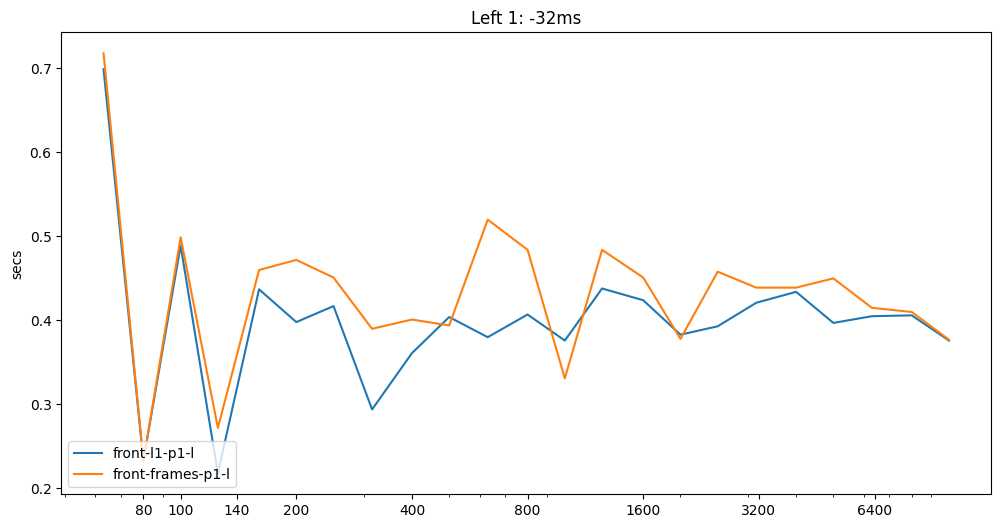

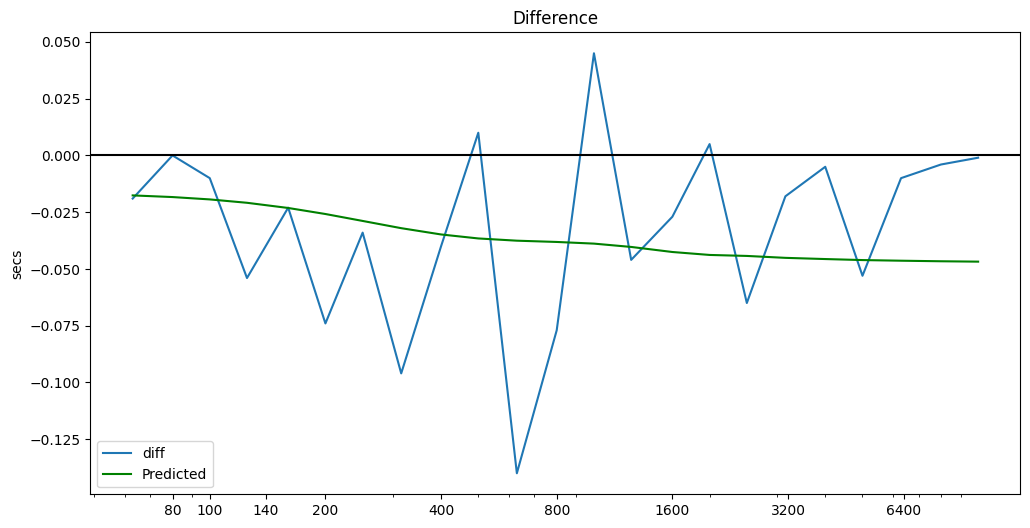

In [14]:
compare_topts("front-l1-p1-l", "front-frames-p1-l", "Left 1", n=2)

## Left 1 & Right 1

Right 1 was added, it is idential to left 1 placed at the same location on the opposite right wall.

We'll skip SPLs here as there's no new information there.

We're at 4 cells now, with 18ms predicted for each we'd expect to see a reduction of 72ms. We see that for the right channel, but not the left and the center is somewhere in between. The likely explination for the discrepancy is that we do not have a fully diffuse sound field and thus aren't completely utilizing the panel's abilities. We'll have to explore this later as we start to incorporate diffusion into the room.

In [15]:
per_channel_topts("front-l1-r1-p1", "front-frames-p1")

topt(front-frames-p1) topt(front-l1-r1-p1) change
l   432ms 375ms -57ms
r   432ms 362ms -70ms
c   410ms 344ms -66ms


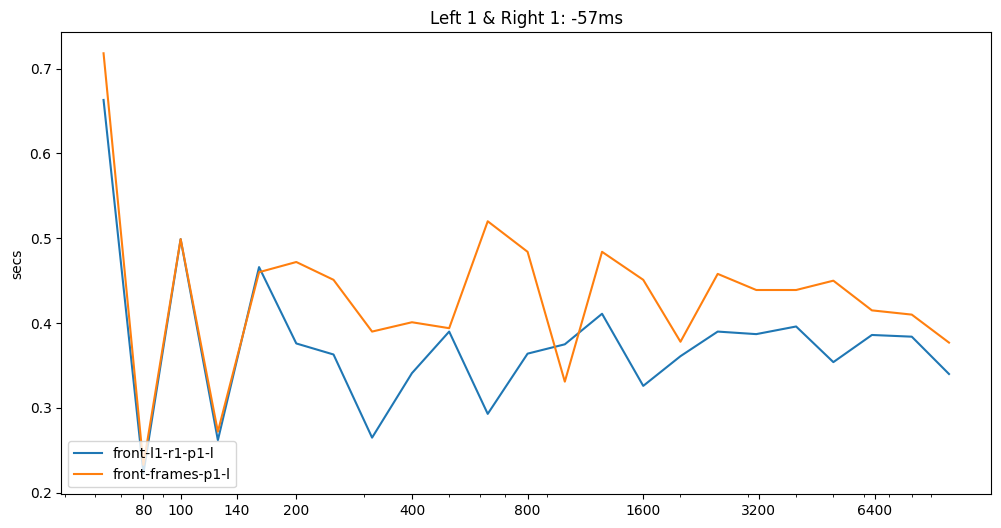

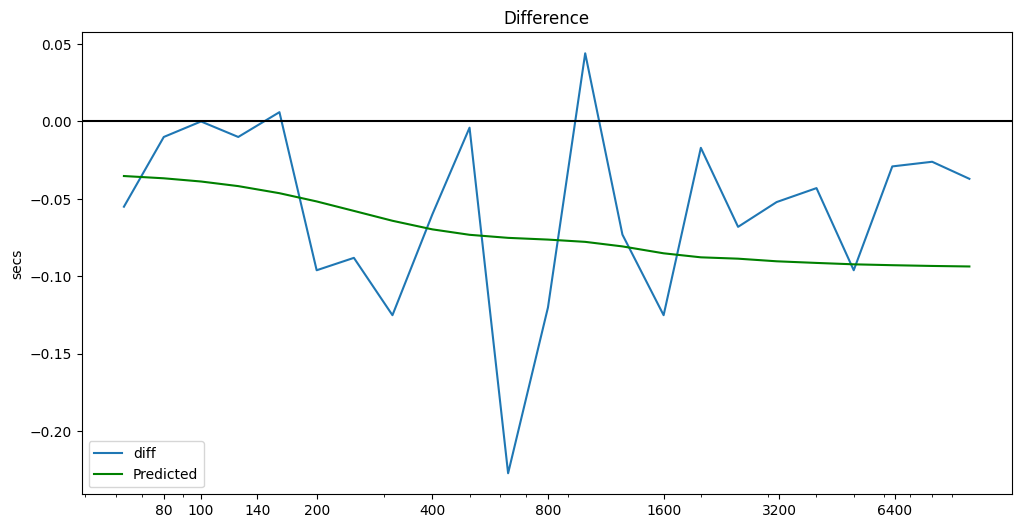

In [16]:
compare_topts("front-l1-r1-p1-l", "front-frames-p1-l", "Left 1 & Right 1", n=4)

## Left 1/2 & Right 1

<img src="../images/front-l12.jpg" width=500/>

Left 2 was added. It's upper cell is filled with porous absorbent and lower cell is empty. As can be seen from the tilt the twisted thin wire used to suspent the frame wasn't quite up to the task and as a precaution the heavier left 1 panel was sat atop the template/spacer created for aligning them when hanging.

This adds a single cell for a total of 5 now. 18ms x 5 = 90ms expected. The results here are interesting. We pick up a full 21ms for the left channel, but the center channel is essentially unchanged and the right channel only drops 7ms.

In [17]:
per_channel_topts("front-l12-r1-p1", "front-frames-p1")

topt(front-frames-p1) topt(front-l12-r1-p1) change
l   432ms 353ms -78ms
r   432ms 364ms -69ms
c   410ms 338ms -73ms


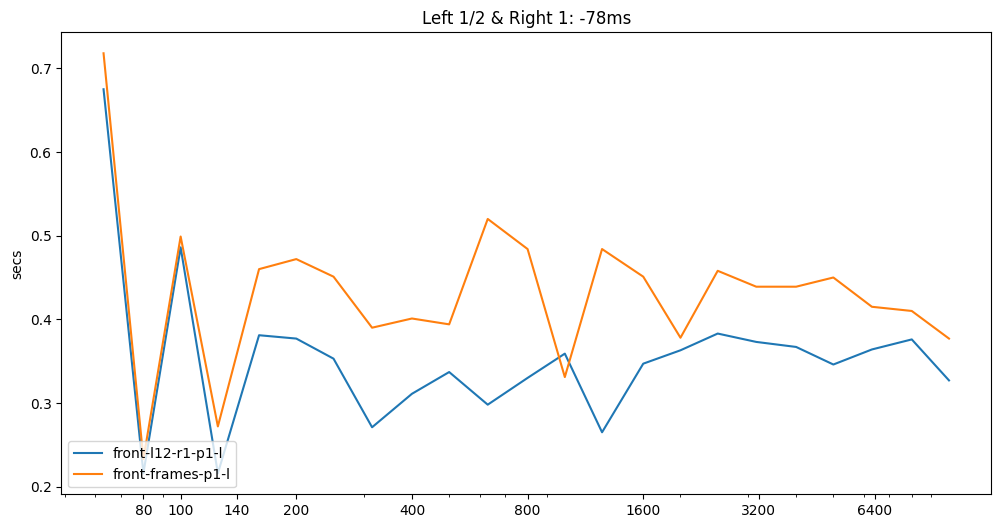

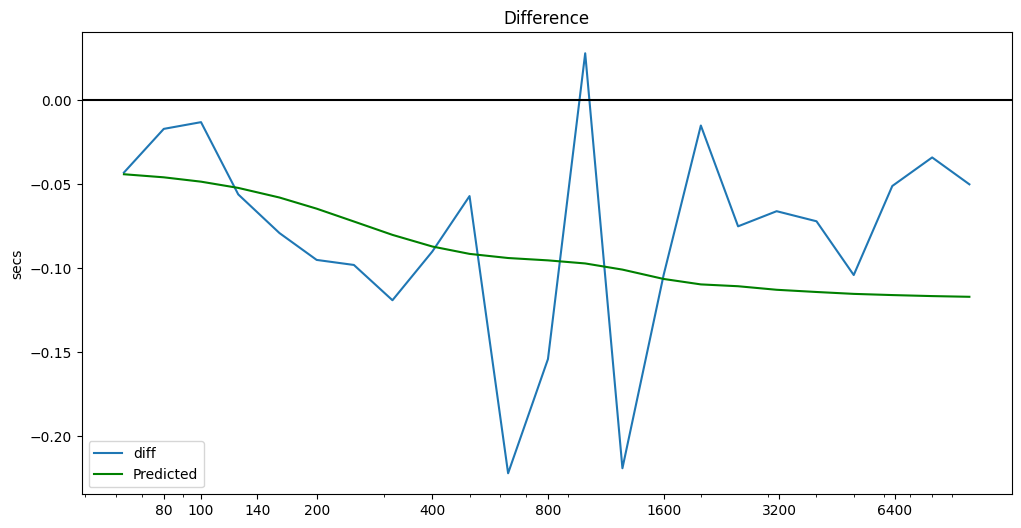

In [18]:
compare_topts("front-l12-r1-p1-l", "front-frames-p1-l", "Left 1/2 & Right 1", n=5)

## Left 1/2 & Right 1/2

The final treatment was added to the right side, idential to the one placed previously on the left with an empty lower cell and upper cell filled with porous absorbent.

We're at 6 cells now and expecting ~108ms reduction. We don't quite get there. Similar to the previous addition on the left adding the new right panel didn't make much of a change for the left channel with a reduction of 4ms, but the right channel picked up an additional 19ms. The center is up ten.

In [19]:
per_channel_topts("front-l12-r12-p1", "front-frames-p1")

topt(front-frames-p1) topt(front-l12-r12-p1) change
l   432ms 350ms -82ms
r   432ms 353ms -79ms
c   410ms 320ms -90ms


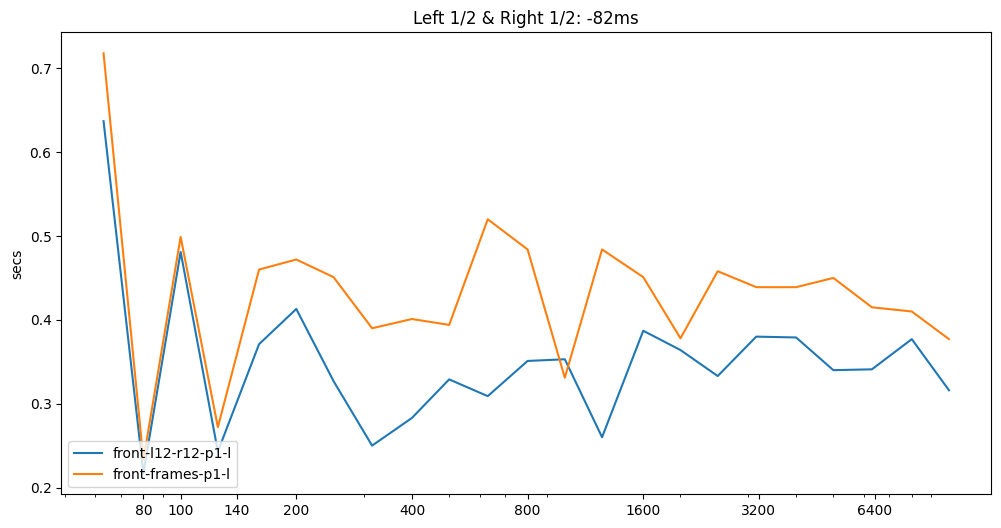

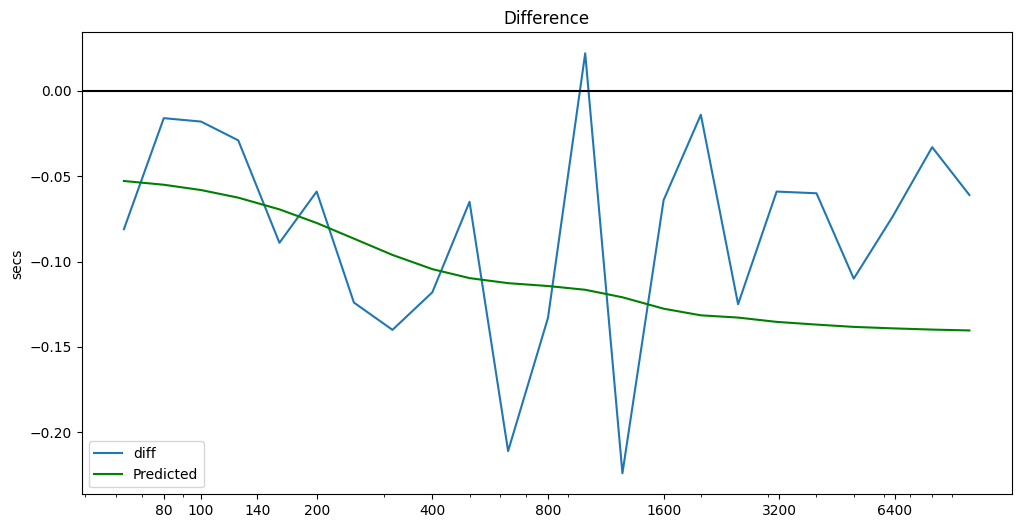

In [20]:
compare_topts("front-l12-r12-p1-l", "front-frames-p1-l", "Left 1/2 & Right 1/2", n=6)

### First Reflections

<img src="../images/first-reflections-left.png" width=500/>

These panels impact the left and right channel's first reflection points for all 3 seating positions so we'll take a moment here to look at it's impact on them.

As laid out in the first-reflection-test notebook the left channel's first reflection path is roughly 0.334m longer than the direct path resulting in around 0.974ms of delay. As expected we see a significant drop in the p1 impulse response around 9ms.

The p2 listening point is roughly 1m to the left of p1 and as a result has a much shallower first reflection angle and shorter additional travel time. We can likely see the impact of both of those below in a small left shift of the impact and an overall reduction in its magnitude. Note the actual point for p2 lies in the open lower cell, but the thickness of the front cell completely ocludes it so we get most if not all of the benefit.

p3 is roughly 0.68m to the right of p1 and has a slightly steeper angle and longer additional travel time. Here we see the additional time, but no real signs of a change in magnitude as both p1 and p2's angles are well within the range where the absorber performs strongly.

In [21]:
def compare_ir(a, b, title, tmax=1.0):
    a_data = impulse_responses[a]["data"][impulse_responses[a]["start"] :]
    b_data = impulse_responses[b]["data"][impulse_responses[b]["start"] :]
    ax = compare_impulse_responses(rate, a, a_data, b, b_data, title, tmax=tmax)

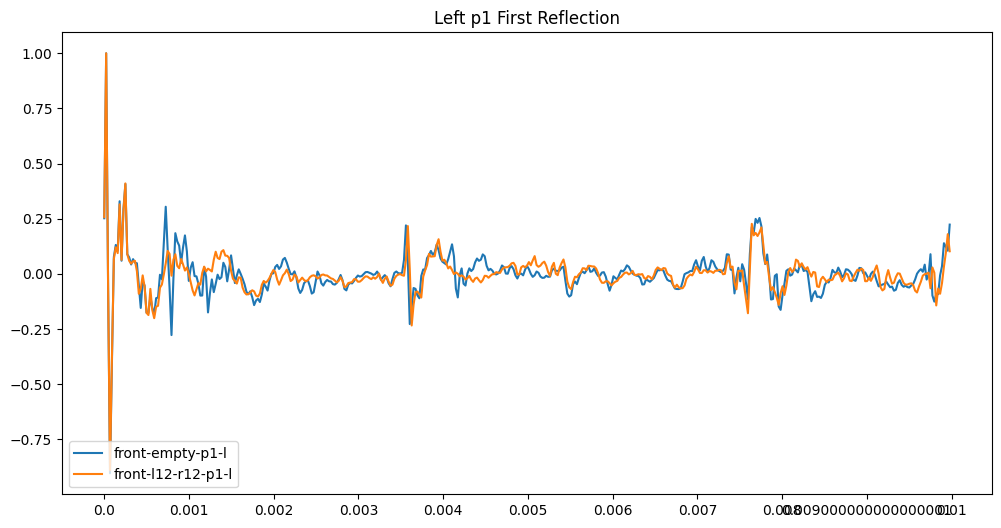

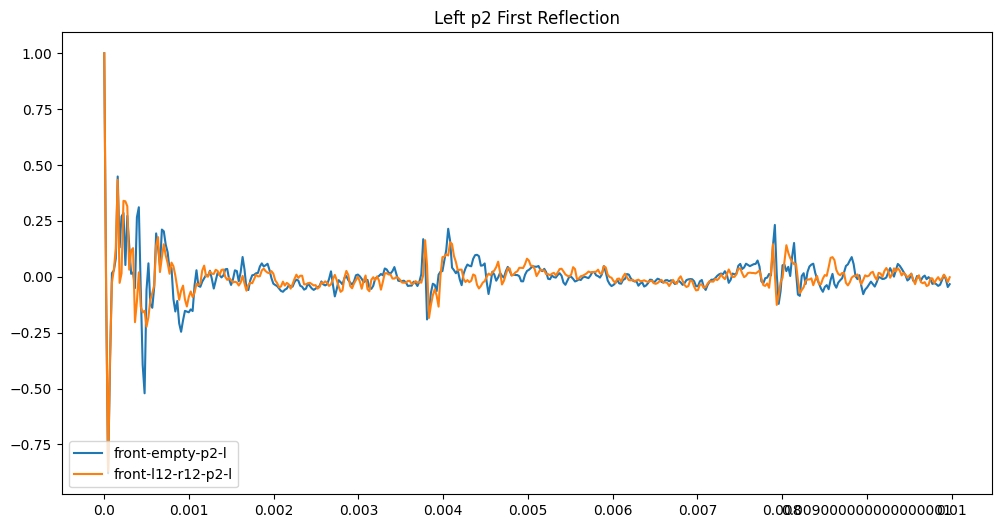

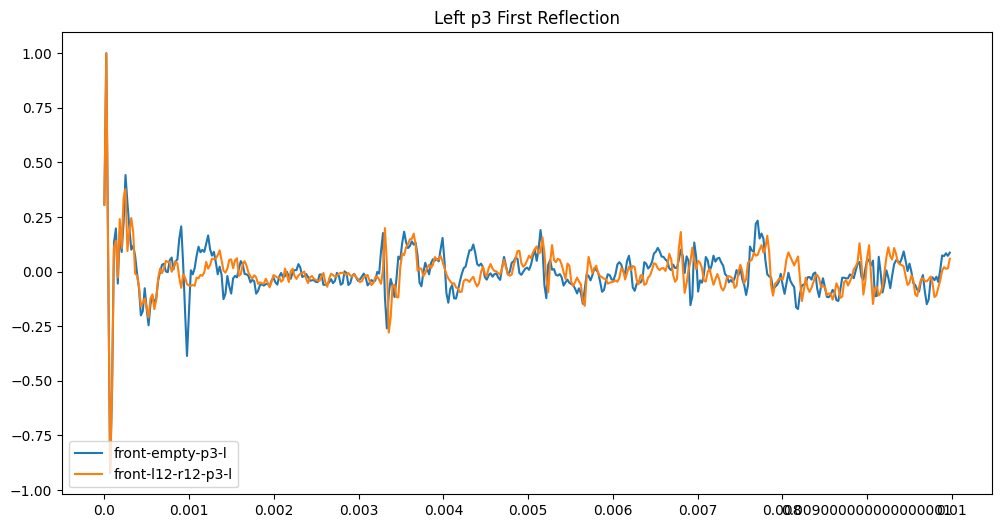

In [22]:
compare_ir(
    "front-empty-p1-l", "front-l12-r12-p1-l", "Left p1 First Reflection", tmax=0.01
)
compare_ir(
    "front-empty-p2-l", "front-l12-r12-p2-l", "Left p2 First Reflection", tmax=0.01
)
compare_ir(
    "front-empty-p3-l", "front-l12-r12-p3-l", "Left p3 First Reflection", tmax=0.01
)

The results for the right channel are largely the same.

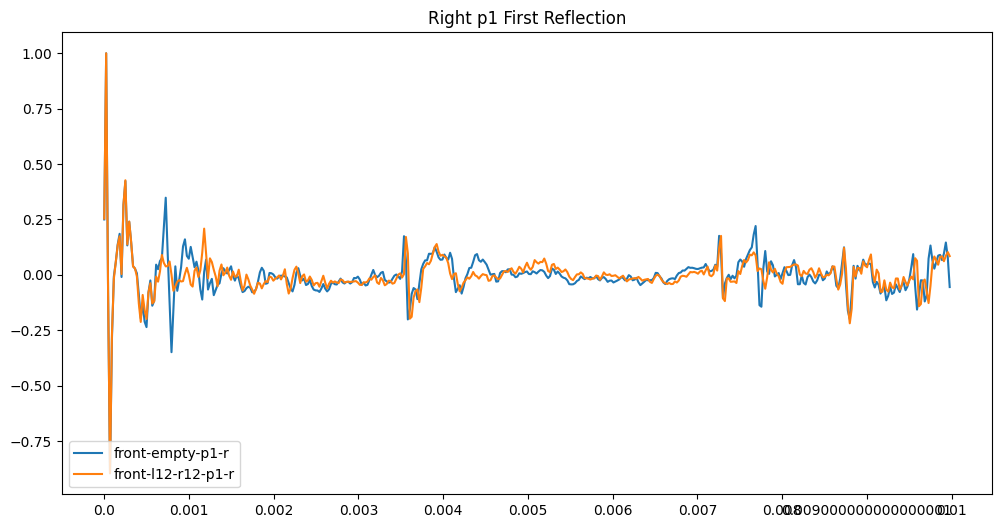

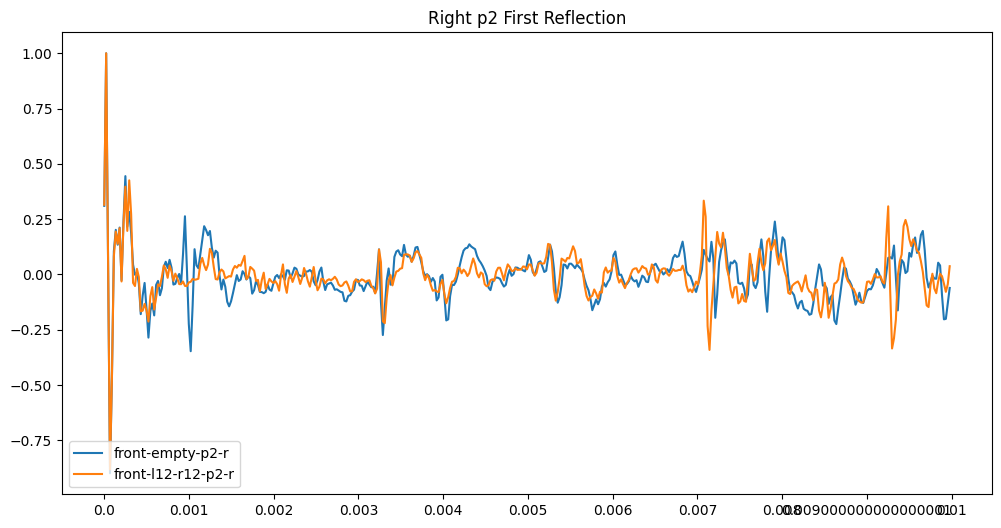

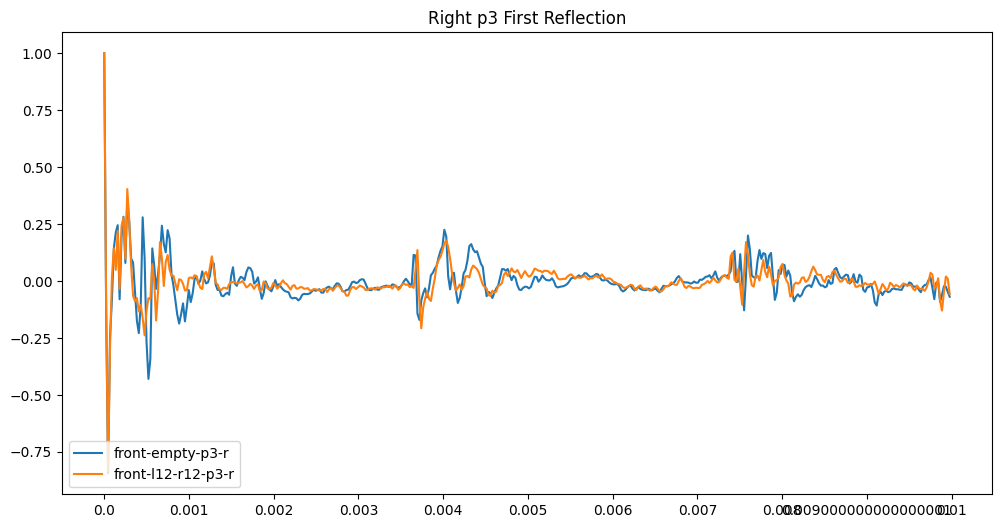

In [23]:
compare_ir(
    "front-empty-p1-r", "front-l12-r12-p1-r", "Right p1 First Reflection", tmax=0.01
)
compare_ir(
    "front-empty-p2-r", "front-l12-r12-p2-r", "Right p2 First Reflection", tmax=0.01
)
compare_ir(
    "front-empty-p3-r", "front-l12-r12-p3-r", "Right p3 First Reflection", tmax=0.01
)

No real impact on the first reflections of the center channel are seen. This is likely due to its first reflection points landing in the open cells that will likely hold diffusers in the future. We'll have to return to this at that point.

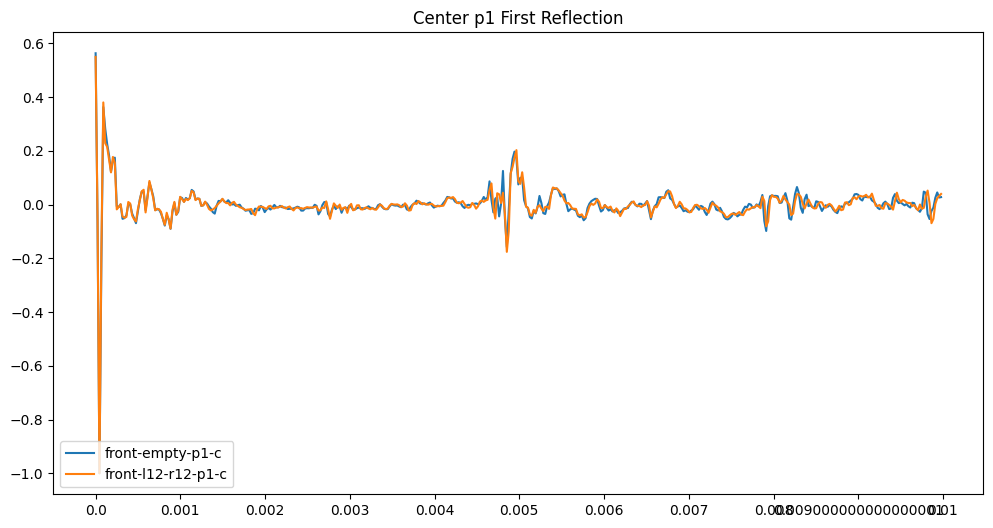

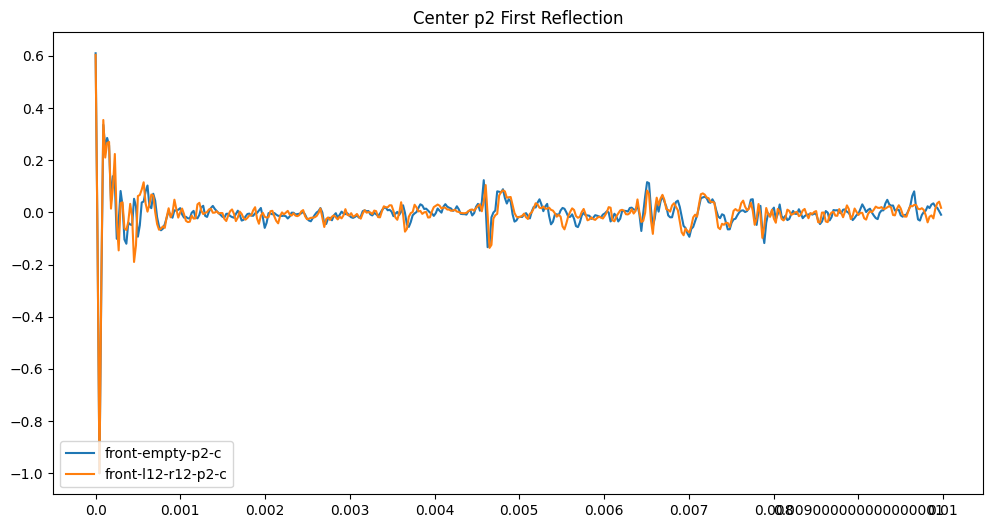

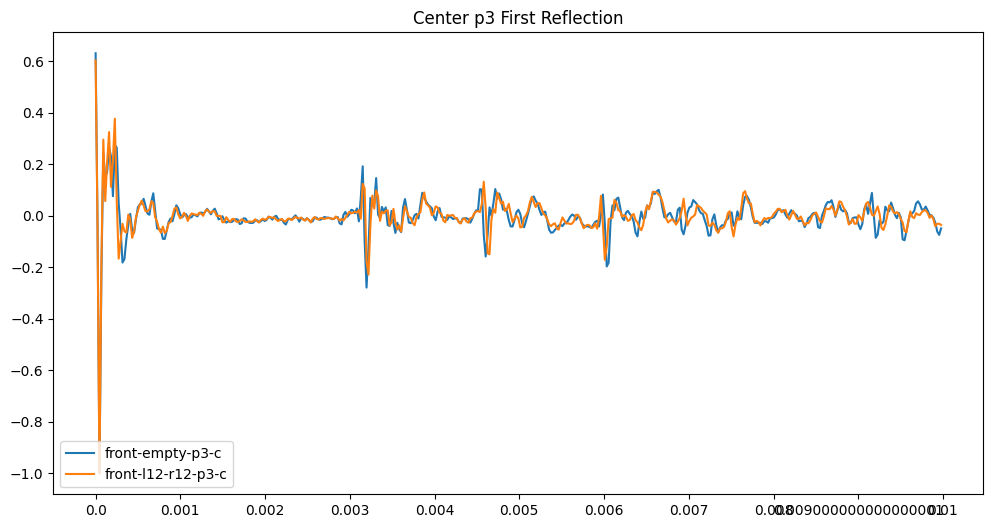

In [24]:
compare_ir(
    "front-empty-p1-c", "front-l12-r12-p1-c", "Center p1 First Reflection", tmax=0.01
)
compare_ir(
    "front-empty-p2-c", "front-l12-r12-p2-c", "Center p2 First Reflection", tmax=0.01
)
compare_ir(
    "front-empty-p3-c", "front-l12-r12-p3-c", "Center p3 First Reflection", tmax=0.01
)